In [1]:
import pandas as pd

def loadCSV(path):
    df = pd.read_csv(path)
    df.reset_index()
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    df =  df.sort_index(ascending=True)
    
    return df

In [2]:
dfd_o = loadCSV("AAPL_1992_2019_daily.csv")
print(dfd_o.info())
df4h_o = loadCSV("E:\Day Trading\Historical Data\AAPL_2004_2019_4h.csv")

df10m_o = loadCSV("E:\Day Trading\Historical Data\AAPL_2004_2019_10m.csv")

df30m_o = loadCSV("E:\Day Trading\Historical Data\AAPL_2004_2019_30m.csv")

df5m_o = loadCSV("E:\Day Trading\Historical Data\AAPL_2004_2019_5m.csv")
# print(dfd_o.info())
# print(df4h_o.info())
# print(df10m_o.info())
# print(df30m_o.info())
# print(df5m_o.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7050 entries, 1992-01-08 to 2019-12-31
Data columns (total 19 columns):
open              7050 non-null float64
high              7050 non-null float64
low               7050 non-null float64
close             7050 non-null float64
volume            7050 non-null int64
average           7050 non-null float64
year              7050 non-null int64
month             7050 non-null int64
day               7050 non-null int64
gap               7049 non-null float64
avg50_volume      7001 non-null float64
angle_2d          7048 non-null float64
momo_90d          6961 non-null float64
tr                7050 non-null float64
atr_6d            7045 non-null float64
ema21             7050 non-null float64
ema50             7050 non-null float64
ema200            7050 non-null float64
stdev50_volume    7050 non-null float64
dtypes: float64(15), int64(4)
memory usage: 1.1 MB
None


FileNotFoundError: [Errno 2] File b'E:\\Day Trading\\Historical Data\\AAPL_2004_2019_4h.csv' does not exist: b'E:\\Day Trading\\Historical Data\\AAPL_2004_2019_4h.csv'

In [3]:
import datetime
# train: 04-10 validation:10-14 test: 14-19
overall_start = datetime.datetime(2004, 1, 24, 4, 0, 0)
overall_end = datetime.datetime(2019, 12, 31, 20, 0, 0)

training_start = datetime.datetime(2004, 2, 24, 4, 0, 0)
training_end = datetime.datetime(2010, 12, 31, 20, 0, 0)

validation_start = datetime.datetime(2011, 1, 1, 4, 0, 0)
validation_end = datetime.datetime(2014, 12, 31, 20, 0, 0)

test_start = datetime.datetime(2015, 1, 1, 4, 0, 0)
test_end = datetime.datetime(2019, 12, 31, 20, 0, 0)

# Cleaning dataset
def trim_data(data, start, end, label=''):
    if label == '':
        return data[start:end]
    else:
        df_labels = data[start:end][label]
        df_data = data[start:end].drop(label, axis=1)
        return df_data, df_labels

def define_dtypes(data):
    convert_dict = {'open': 'float64', 
                    'high': 'float64'
                   } 
    return data.astype(convert_dict) 

dfd_all = trim_data(dfd_o, overall_start, overall_end)

df4h_all = trim_data(df4h_o, overall_start, overall_end)

df10m_all = trim_data(df10m_o, overall_start, overall_end)

df30m_all = trim_data(df30m_o, overall_start, overall_end)

df5m_all = trim_data(df5m_o, overall_start, overall_end)
# print(dfd_all.index)
# print(dfd_all.isna().sum())
# print(df4h_all.index)
# print(df4h_all.isna().sum())
# print(df10m_all.index)
# print(df10m_all.isna().sum())
# print(df30m_all.index)
# print(df30m_all.isna().sum())
# print(df5m_all.index)
# print(df5m_all.isna().sum())

In [4]:
# build daily dataset
def add_EMAs(data):
    df = data.copy()
    df['ema21'] = df['close'].ewm(span=21,adjust=False,ignore_na=False).mean()
    df['ema50'] = df['close'].ewm(span=50,adjust=False,ignore_na=False).mean()
    df['ema200'] = df['close'].ewm(span=200,adjust=False,ignore_na=False).mean()
    return df

def add_MACD(data):
    df = data.copy()
    exp1 = df.close.ewm(span=12, adjust=False).mean()
    exp2 = df.close.ewm(span=26, adjust=False).mean()
    df['macd_value'] = exp1-exp2
    df['macd'] = df['macd_value'].ewm(span=9, adjust=False).mean()
    return df

def addon_5m_tone(df, dfm):
    df = df.copy()
    dfm = dfm.copy()
    
    #dfm['tr'] = dfm['close'] - dfm['open']
    
    
    df.reset_index(drop=False, inplace=True)
    
    p_o = datetime.time(4, 0, 0)
    p_c = datetime.time(9, 25, 0)
    df_pre_high = dfm.loc[(dfm.index.time >= p_o) & (dfm.index.time <= p_c)].groupby(['year', 'month', 'day'])['high'].max().reset_index()
    df = df.merge(df_pre_high, on=['year', 'month', 'day'], how='outer', suffixes=(_,'_premarket'), validate='one_to_one')
    df_pre_low = dfm.loc[(dfm.index.time >= p_o) & (dfm.index.time <= p_c)].groupby(['year', 'month', 'day'])['low'].min().reset_index()
    df = df.merge(df_pre_low, on=['year', 'month', 'day'], how='outer', suffixes=(_,'_premarket'), validate='one_to_one')
    
    a_o = datetime.time(16, 5, 0)
    a_c = datetime.time(20, 0, 0)
    df_af_high = dfm.loc[(dfm.index.time >= a_o) & (dfm.index.time <= a_c)].groupby(['year', 'month', 'day'])['high'].max().reset_index()
    df = df.merge(df_af_high, on=['year', 'month', 'day'], how='outer', suffixes=(_,'_aftermarket'), validate='one_to_one')
    df_af_low = dfm.loc[(dfm.index.time >= p_o) & (dfm.index.time <= p_c)].groupby(['year', 'month', 'day'])['low'].min().reset_index()
    df = df.merge(df_af_low, on=['year', 'month', 'day'], how='outer', suffixes=(_,'_aftermarket'), validate='one_to_one')
    
    df3 = df.merge(dfm[['high', 'low', 'volume', 'close', 'open', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 30)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_5m_1st'), validate='one_to_one')
    df3 = df3.merge(dfm[['high', 'low', 'volume', 'close', 'open', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 35)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_5m_2nd'), validate='one_to_one')
    df3 = df3.merge(dfm[['high', 'low', 'volume', 'close', 'open', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 40)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_5m_3rd'), validate='one_to_one')
    df3 = df3.merge(dfm[['high', 'low', 'volume', 'close', 'open', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 45)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_5m_4th'), validate='one_to_one')
    df3 = df3.merge(dfm[['high', 'low', 'volume', 'close', 'open', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 50)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_5m_5th'), validate='one_to_one')
    df3 = df3.merge(dfm[['high', 'low', 'volume', 'close', 'open', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 55)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_5m_6th'), validate='one_to_one')
    #!!!!!!! another way is to use 'one_to_many', then sort by date, drop duplicates and keep first
    df3.reset_index(drop=True, inplace=True)
    df3.set_index('date', inplace=True)
    df3.index = pd.to_datetime(df3.index)
    df3 =  df3.sort_index(ascending=True)
    
    df3['drvol_5m_1st'] = (df3.volume_5m_1st - df3.avg50_volume) / df3.stdev50_volume
    df3['drvol_5m_2nd'] = (df3.volume_5m_2nd - df3.avg50_volume) / df3.stdev50_volume
    df3['drvol_5m_3rd'] = (df3.volume_5m_3rd - df3.avg50_volume) / df3.stdev50_volume
    df3['drvol_5m_4th'] = (df3.volume_5m_4th - df3.avg50_volume) / df3.stdev50_volume
    df3['drvol_5m_5th'] = (df3.volume_5m_5th - df3.avg50_volume) / df3.stdev50_volume
    df3['drvol_5m_6th'] = (df3.volume_5m_6th - df3.avg50_volume) / df3.stdev50_volume
    
    #print(df3.tail())
    return df3

def addon_10m_EMAs(df, dfm):
    df = df.copy()
    dfm = dfm.copy()
    df.reset_index(drop=False, inplace=True)
    df3 = df.merge(dfm[['ema21', 'ema50', 'ema200', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 30)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_10m_1st'), validate='one_to_one')
    df3.reset_index(drop=True, inplace=True)
    df3.set_index('date', inplace=True)
    df3.index = pd.to_datetime(df3.index)
    df3 =  df3.sort_index(ascending=True)
    
    return df3

def addon_10m_MACD(df, dfm):
    df = df.copy()
    dfm = dfm.copy()
    df.reset_index(drop=False, inplace=True)
    df3 = df.merge(dfm[['macd', 'macd_value', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 30)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_10m_1st'), validate='one_to_one')
    df3.reset_index(drop=True, inplace=True)
    df3.set_index('date', inplace=True)
    df3.index = pd.to_datetime(df3.index)
    df3 =  df3.sort_index(ascending=True)
    df3.rename(columns={"macd": "macd_10m_1st", "macd_value": "macd_value_10m_1st"}, inplace=True)
    
    return df3

def addon_4h_EMAs(df, dfm):
    df = df.copy()
    dfm = dfm.copy()
    df.reset_index(drop=False, inplace=True)
    df3 = df.merge(dfm[['ema21', 'ema50', 'ema200', 'year', 'month', 'day']].loc[(dfm.hour > 4) & (dfm.hour < 11)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_4h_1st'), validate='one_to_one')
    df3.reset_index(drop=True, inplace=True)
    df3.set_index('date', inplace=True)
    df3.index = pd.to_datetime(df3.index)
    df3 =  df3.sort_index(ascending=True)
    
    return df3

def addon_4h_MACD(df, dfm):
    df = df.copy()
    dfm = dfm.copy()
    df.reset_index(drop=False, inplace=True)
    df3 = df.merge(dfm[['macd', 'macd_value', 'year', 'month', 'day']].loc[(dfm.hour > 4) & (dfm.hour < 11)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_4h_1st'), validate='one_to_one')
    df3.reset_index(drop=True, inplace=True)
    df3.set_index('date', inplace=True)
    df3.index = pd.to_datetime(df3.index)
    df3 =  df3.sort_index(ascending=True)
    df3.rename(columns={"macd": "macd_4h_1st", "macd_value": "macd_value_4h_1st"}, inplace=True)
    
    return df3

def addon_30m_candle(df, dfm):
    df = df.copy()
    dfm = dfm.copy()
    df.reset_index(drop=False, inplace=True)
    df3 = df.merge(dfm[['high', 'low', 'close', 'year', 'month', 'day']].loc[(dfm.hour == 9) & (dfm.minute == 30)], on=['year', 'month', 'day'], how='outer', suffixes=(_,'_30m_1st'), validate='one_to_one')
    df3.reset_index(drop=True, inplace=True)
    df3.set_index('date', inplace=True)
    df3.index = pd.to_datetime(df3.index)
    df3 =  df3.sort_index(ascending=True)
    return df3

In [5]:
# For 4h
df4h_all = add_EMAs(df4h_all)
df4h_all = add_MACD(df4h_all)
#print(df4h_all.tail(10)) # 08 - 11  04 - 07 - 11

# For 10m
df10m_all = add_EMAs(df10m_all)
df10m_all = add_MACD(df10m_all)

# For 5m
df5m_all = add_EMAs(df5m_all)

# For daily
dfd_all = add_EMAs(dfd_all)
dfd_all = addon_5m_tone(dfd_all, df5m_all)
dfd_all = addon_10m_EMAs(dfd_all, df10m_all)
dfd_all = addon_10m_MACD(dfd_all, df10m_all)
dfd_all = addon_30m_candle(dfd_all, df30m_all)

# add labels
dfd_all['yst_high'] = dfd_all['high'].shift(1)
dfd_all['yst_low'] = dfd_all['low'].shift(1)
dfd_all['atr_chg'] = dfd_all['tr']/dfd_all['atr_6d']
dfd_all['atr_label'] = ((dfd_all['atr_chg'] >= 0.5) | (dfd_all['atr_chg'] <= -0.5))
#dfd_all = addon_4h_EMAs(dfd_all, df4h_all)
#dfd_all = addon_4h_MACD(dfd_all, df4h_all)

In [6]:
# print(dfd_all.tail())
# print(dfd_all.isna().sum())
# print(dfd_all[dfd_all == 0].count(axis=0))

In [7]:
df5m_all.loc[(df5m_all.index.year == 2007) & (df5m_all.index.month == 5) & (df5m_all.index.day == 11) & (df5m_all.index.hour == 9)]

open   high    low  close  volume    average  year  \
date                                                                       
2007-05-11 09:00:00  15.34  15.36  15.34  15.35     581  15.352429  2007   
2007-05-11 09:05:00  15.36  15.36  15.35  15.35     854  15.352857  2007   
2007-05-11 09:10:00  15.36  15.36  15.35  15.36     343  15.356429  2007   
2007-05-11 09:15:00  15.36  15.36  15.36  15.36     518  15.362429  2007   
2007-05-11 09:20:00  15.36  15.36  15.36  15.36       0  15.357143  2007   
2007-05-11 09:25:00  15.36  15.36  15.36  15.36       0  15.357143  2007   
2007-05-11 09:30:00  15.36  15.36  15.36  15.36       0  15.357143  2007   
2007-05-11 09:35:00  15.36  15.36  15.36  15.36       0  15.357143  2007   
2007-05-11 09:40:00  15.39  15.47  15.39  15.45   11382  15.438714  2007   
2007-05-11 09:45:00  15.45  15.45  15.36  15.39   41328  15.393714  2007   
2007-05-11 09:50:00  15.39  15.41  15.24  15.40   69860  15.366000  2007   
2007-05-11 09:55:00  15.40  15.47  15.31  15.33   53053  15.394143  2007   

                     month  day  hour  minute      ema21      ema50     ema200  
date                                                                            
2007-05-11 09:00:00      5   11     9       0  15.327199  15.333440  15.300470  
2007-05-11 09:05:00      5   11     9       5  15.329272  15.334090  15.300963  
2007-05-11 09:10:00      5   11     9      10  15.332066  15.335106  15.301551  
2007-05-11 09:15:00      5   11     9      15  15.334605  15.336082  15.302132  
2007-05-11 09:20:00      5   11     9      20  15.336914  15.337020  15.302708  
2007-05-11 09:25:00      5   11     9      25  15.339012  15.337921  15.303278  
2007-05-11 09:30:00      5   11     9      30  15.340920  15.338787  15.303842  
2007-05-11 09:35:00      5   11     9      35  15.342655  15.339619  15.304401  
2007-05-11 09:40:00      5   11     9      40  15.352414  15.343948  15.305850  
2007-05-11 09:45:00      5   11     9      45  15.355831  15.345753  15.306687  
2007-05-11 09:50:00      5   11     9      50  15.359846  15.347881  15.307616  
2007-05-11 09:55:00      5   11     9      55  15.357133  15.347180  15.307838

In [8]:
print(dfd_all.columns)
print(dfd_all['high_aftermarket'].dtypes)

Index(['open', 'high', 'low', 'close', 'volume', 'average', 'year', 'month',
       'day', 'gap', 'avg50_volume', 'angle_2d', 'momo_90d', 'tr', 'atr_6d',
       'ema21', 'ema50', 'ema200', 'stdev50_volume', 'high_premarket',
       'low_premarket', 'high_aftermarket', 'low_aftermarket', 'high_5m_1st',
       'low_5m_1st', 'volume_5m_1st', 'close_5m_1st', 'open_5m_1st',
       'high_5m_2nd', 'low_5m_2nd', 'volume_5m_2nd', 'close_5m_2nd',
       'open_5m_2nd', 'high_5m_3rd', 'low_5m_3rd', 'volume_5m_3rd',
       'close_5m_3rd', 'open_5m_3rd', 'high_5m_4th', 'low_5m_4th',
       'volume_5m_4th', 'close_5m_4th', 'open_5m_4th', 'high_5m_5th',
       'low_5m_5th', 'volume_5m_5th', 'close_5m_5th', 'open_5m_5th',
       'high_5m_6th', 'low_5m_6th', 'volume_5m_6th', 'close_5m_6th',
       'open_5m_6th', 'drvol_5m_1st', 'drvol_5m_2nd', 'drvol_5m_3rd',
       'drvol_5m_4th', 'drvol_5m_5th', 'drvol_5m_6th', 'ema21_10m_1st',
       'ema50_10m_1st', 'ema200_10m_1st', 'macd_10m_1st', 'macd_value_10m_

In [9]:
import sys

# label: atr_chg


train_o = trim_data(dfd_all, training_start, training_end)
train_o.dropna(inplace=True)
print(train_o.isna().sum())

#print(train_o[train_o == 0].count(axis=0))
#print(train_o.loc[train_o['high_30m_1st'].isna()])

open             0
high             0
low              0
close            0
volume           0
                ..
close_30m_1st    0
yst_high         0
yst_low          0
atr_chg          0
atr_label        0
Length: 71, dtype: int64


C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
# Feature Engineering

# issues: volume number is large(normalization to M), price is different from stock to stock(normalization or its fine),
# intraday price to 0.3atr% ?
def feature_extraction_daily(df):
    df = df.copy()
    
    df['month'] = df['month'].astype('int32')
    df['volume_m'] = df['volume'] / 1000000
    df['avg50_volume_m'] = df['avg50_volume'] / 1000000
    
    def close_to_prehigh_chg(x, field):
        highest = max([x['high_aftermarket'], x['high_premarket'], x['yst_high']])
        return (x[field] - highest)/x['atr_6d']
    def close_to_prelow_chg(x, field):
        lowest = min([x['low_aftermarket'], x['low_premarket'], x['yst_low']])
        return (x[field] - lowest)/x['atr_6d']
    
    # candle shape study
    df['high_5m_1st_chg'] = (df['high_5m_1st'] - df['open']) / df['atr_6d']
    df['low_5m_1st_chg'] = (df['low_5m_1st'] - df['open']) / df['atr_6d']
    df['close_5m_1st_chg'] = (df['close_5m_1st'] - df['open']) / df['atr_6d']
    df['close_of_prehigh_5m_1st_chg'] = df.apply(close_to_prehigh_chg, field='close_5m_1st', axis=1)
    df['close_of_prelow_5m_1st_chg'] = df.apply(close_to_prelow_chg, field='close_5m_1st', axis=1)
    df['close_of_high_1st_chg'] = (df['high_5m_1st'] - df['close_5m_1st']) / df['atr_6d']
    df['close_of_low_1st_chg'] = (df['close_5m_1st'] - df['low_5m_1st']) / df['atr_6d']
    
    df['high_5m_2nd_chg'] = (df['high_5m_2nd'] - df['open']) / df['atr_6d']
    df['low_5m_2nd_chg'] = (df['low_5m_2nd'] - df['open']) / df['atr_6d']
    df['close_5m_2nd_chg'] = (df['close_5m_2nd'] - df['open']) / df['atr_6d']
    df['close_of_prehigh_5m_2nd_chg'] = df.apply(close_to_prehigh_chg, field='close_5m_2nd', axis=1)
    df['close_of_prelow_5m_2nd_chg'] = df.apply(close_to_prelow_chg, field='close_5m_2nd', axis=1)
    df['close_of_high_2nd_chg'] = (df['high_5m_2nd'] - df['close_5m_2nd']) / df['atr_6d']
    df['close_of_low_2nd_chg'] = (df['close_5m_2nd'] - df['low_5m_2nd']) / df['atr_6d']
    
    df['close2nd_of_close1st_chg'] = (df['close_5m_2nd'] - df['close_5m_1st'])/df['atr_6d']
    
#     df['high_5m_3rd_chg'] = (df['high_5m_3rd'] - df['open']) / df['atr_20d']
#     df['low_5m_3rd_chg'] = (df['low_5m_3rd'] - df['open']) / df['atr_20d']
#     df['close_5m_3rd_chg'] = (df['close_5m_3rd'] - df['open']) / df['atr_20d']
    
#     df['high_5m_4th_chg'] = (df['high_5m_4th'] - df['open']) / df['atr_20d']
#     df['low_5m_4th_chg'] = (df['low_5m_4th'] - df['open']) / df['atr_20d']
#     df['close_5m_4th_chg'] = (df['close_5m_4th'] - df['open']) / df['atr_20d']
    
#     df['high_5m_5th_chg'] = (df['high_5m_5th'] - df['open']) / df['atr_20d']
#     df['low_5m_5th_chg'] = (df['low_5m_5th'] - df['open']) / df['atr_20d']
#     df['close_5m_5th_chg'] = (df['close_5m_5th'] - df['open']) / df['atr_20d']
    
#     df['high_5m_6th_chg'] = (df['high_5m_6th'] - df['open']) / df['atr_20d']
#     df['low_5m_6th_chg'] = (df['low_5m_6th'] - df['open']) / df['atr_20d']
#     df['close_5m_6th_chg'] = (df['close_5m_6th'] - df['open']) / df['atr_20d']
    
    df['high_30m_1st_chg'] = (df['high_30m_1st'] - df['open']) / df['atr_6d']
    df['low_30m_1st_chg'] = (df['low_30m_1st'] - df['open']) / df['atr_6d']
    df['close_30m_1st_chg'] = (df['close_30m_1st'] - df['open']) / df['atr_6d']
    
    df['macd_diff_10m_1st'] = df['macd_value_10m_1st'] - df['macd_10m_1st']
    
    return df
    
def binary_feature_extraction_daily(df):
    df = df.copy()
    
    def ema_trend_10m(x):
        trend = ""
        if x['ema21_10m_1st'] > x['ema50_10m_1st'] and x['ema50_10m_1st'] > x['ema200_10m_1st']:
            trend = "Up Trend"
        elif x['ema21_10m_1st'] < x['ema50_10m_1st'] and x['ema50_10m_1st'] < x['ema200_10m_1st']:
            trend = "Down Trend"
        else:
            trend = "Range"
            
        return trend
    
    df['ema_trend_10m_1st'] = df.apply(ema_trend_10m, axis=1)
    
    return df
    
def drop_useless_columns(df):
    return df.drop(['average', 'year', 'day', 'stdev50_volume', 'volume', 'volume_m', 'avg50_volume',
             'high_5m_1st', 'low_5m_1st', 'volume_5m_1st', 'close_5m_1st', 'open_5m_1st',
             'high_5m_2nd', 'low_5m_2nd', 'volume_5m_2nd', 'close_5m_2nd', 'open_5m_2nd', 
             'high_5m_3rd', 'low_5m_3rd', 'volume_5m_3rd', 'close_5m_3rd', 'open_5m_3rd',
             'high_5m_4th', 'low_5m_4th', 'volume_5m_4th', 'close_5m_4th', 'open_5m_4th',
             'high_5m_5th', 'low_5m_5th', 'volume_5m_5th', 'close_5m_5th', 'open_5m_5th',
             'high_5m_6th', 'low_5m_6th', 'volume_5m_6th', 'close_5m_6th', 'open_5m_6th',
             'high_30m_1st', 'low_30m_1st', 'close_30m_1st', 'tr', 'atr_6d',
             'open', 'high', 'low', 'close', 'yst_high', 'yst_low', 
             'high_premarket', 'low_premarket', 'high_aftermarket', 'low_aftermarket',
             'ema21_10m_1st', 'ema50_10m_1st', 'ema200_10m_1st'], axis=1)

def handle_text_columns(df):
    from sklearn.preprocessing import LabelEncoder 
    
    df = df.copy()
    
    encoder = LabelEncoder()
    df_cat = df["ema_trend_10m_1st"] 
    df_cat_encoded = encoder.fit_transform(df_cat) 
    df["ema_trend_10m_1st"] = df_cat_encoded 
    print(encoder.classes_)
        
    return df

train_o = feature_extraction_daily(train_o)
train_o = binary_feature_extraction_daily(train_o)
train_o = handle_text_columns(train_o)
train_o = drop_useless_columns(train_o)

print(train_o.columns)
print(train_o.dtypes)
print(train_o.loc[(train_o['atr_chg'] >= 0.5) | (train_o['atr_chg'] <= -0.5)].describe())
train_o.tail()

['Down Trend' 'Range' 'Up Trend']
Index(['month', 'gap', 'angle_2d', 'momo_90d', 'ema21', 'ema50', 'ema200',
       'drvol_5m_1st', 'drvol_5m_2nd', 'drvol_5m_3rd', 'drvol_5m_4th',
       'drvol_5m_5th', 'drvol_5m_6th', 'macd_10m_1st', 'macd_value_10m_1st',
       'atr_chg', 'atr_label', 'avg50_volume_m', 'high_5m_1st_chg',
       'low_5m_1st_chg', 'close_5m_1st_chg', 'close_of_prehigh_5m_1st_chg',
       'close_of_prelow_5m_1st_chg', 'close_of_high_1st_chg',
       'close_of_low_1st_chg', 'high_5m_2nd_chg', 'low_5m_2nd_chg',
       'close_5m_2nd_chg', 'close_of_prehigh_5m_2nd_chg',
       'close_of_prelow_5m_2nd_chg', 'close_of_high_2nd_chg',
       'close_of_low_2nd_chg', 'close2nd_of_close1st_chg', 'high_30m_1st_chg',
       'low_30m_1st_chg', 'close_30m_1st_chg', 'macd_diff_10m_1st',
       'ema_trend_10m_1st'],
      dtype='object')
month                            int32
gap                            float64
angle_2d                       float64
momo_90d                       flo

month       gap   angle_2d  momo_90d      ema21      ema50  \
date                                                                     
2010-12-27     12 -0.140601   7.977638  1.820603  45.684943  44.484179   
2010-12-28     12  0.377277   3.833088  1.785951  45.758584  44.563035   
2010-12-29     12  0.182815 -17.357753  1.748507  45.823258  44.637818   
2010-12-30     12  0.032279  -0.433803  1.701736  45.860689  44.700453   
2010-12-31     12 -0.216286  14.578050  1.649537  45.880627  44.754553   

               ema200  drvol_5m_1st  drvol_5m_2nd  drvol_5m_3rd  ...  \
date                                                             ...   
2010-12-27  38.903250     -1.186537     -1.201831     -1.213918  ...   
2010-12-28  38.978789     -1.165183     -1.175191     -1.179492  ...   
2010-12-29  39.053329     -1.127029     -1.138106     -1.137803  ...   
2010-12-30  39.124788     -1.075197     -1.086501     -1.083555  ...   
2010-12-31  39.193994     -1.051734     -1.057163     -1.038216  ...   

            close_of_prehigh_5m_2nd_chg  close_of_prelow_5m_2nd_chg  \
date                                                                  
2010-12-27                    -0.498255                    0.389939   
2010-12-28                    -0.765054                    1.228723   
2010-12-29                    -0.294029                    0.294029   
2010-12-30                    -0.611556                   -0.078071   
2010-12-31                    -1.063676                   -0.079776   

            close_of_high_2nd_chg  close_of_low_2nd_chg  \
date                                                      
2010-12-27               0.216633              0.129980   
2010-12-28               0.347752              0.023183   
2010-12-29               0.076703              0.051135   
2010-12-30               0.026024              0.052047   
2010-12-31               0.212735              0.026592   

            close2nd_of_close1st_chg  high_30m_1st_chg  low_30m_1st_chg  \
date                                                                      
2010-12-27                  0.086653          0.335781        -0.509087   
2010-12-28                 -0.347752          0.255018        -0.255018   
2010-12-29                 -0.076703          0.153406        -0.127838   
2010-12-30                  0.000000          0.039036        -0.481438   
2010-12-31                 -0.079776          0.199439        -0.571726   

            close_30m_1st_chg  macd_diff_10m_1st  ema_trend_10m_1st  
date                                                                 
2010-12-27          -0.314118           0.011840                  0  
2010-12-28           0.023183          -0.017047                  2  
2010-12-29          -0.025568           0.002790                  2  
2010-12-30          -0.429391          -0.003290                  1  
2010-12-31          -0.358991          -0.008091                  0  

[5 rows x 38 columns]

In [11]:
#pd.set_option('display.max_columns', None)  
#pd.set_option('display.expand_frame_repr', False)
#pd.set_option('max_colwidth', -1)


attributes = ['month', 'gap', 'angle_2d', 'momo_90d', 'ema21', 'ema50', 'ema200',
       'drvol_5m_1st', 'drvol_5m_2nd', 'drvol_5m_3rd', 'drvol_5m_4th',
       'drvol_5m_5th', 'drvol_5m_6th', 'macd_10m_1st', 'macd_value_10m_1st',
       'atr_chg', 'atr_label', 'avg50_volume_m', 'high_5m_1st_chg',
       'low_5m_1st_chg', 'close_5m_1st_chg', 'close_of_prehigh_5m_1st_chg',
       'close_of_prelow_5m_1st_chg', 'close_of_high_1st_chg',
       'close_of_low_1st_chg', 'high_5m_2nd_chg', 'low_5m_2nd_chg',
       'close_5m_2nd_chg', 'close_of_prehigh_5m_2nd_chg',
       'close_of_prelow_5m_2nd_chg', 'close_of_high_2nd_chg',
       'close_of_low_2nd_chg', 'close2nd_of_close1st_chg', 'high_30m_1st_chg',
       'low_30m_1st_chg', 'close_30m_1st_chg', 'macd_diff_10m_1st',
       'ema_trend_10m_1st']

print(train_o[attributes].corr()['atr_chg'].sort_values(ascending=False) )

atr_chg                        1.000000
close_30m_1st_chg              0.515026
high_30m_1st_chg               0.415561
close_5m_2nd_chg               0.397867
high_5m_2nd_chg                0.370173
low_30m_1st_chg                0.361618
low_5m_2nd_chg                 0.339823
close_5m_1st_chg               0.309228
close2nd_of_close1st_chg       0.241647
high_5m_1st_chg                0.235599
low_5m_1st_chg                 0.229164
macd_diff_10m_1st              0.182998
close_of_low_1st_chg           0.177169
close_of_low_2nd_chg           0.169428
close_of_prelow_5m_2nd_chg     0.093404
drvol_5m_2nd                   0.074575
drvol_5m_5th                   0.074450
drvol_5m_6th                   0.074224
drvol_5m_3rd                   0.074055
drvol_5m_4th                   0.073879
drvol_5m_1st                   0.072591
close_of_prelow_5m_1st_chg     0.060036
macd_value_10m_1st             0.051354
ema_trend_10m_1st              0.030013
month                          0.015014


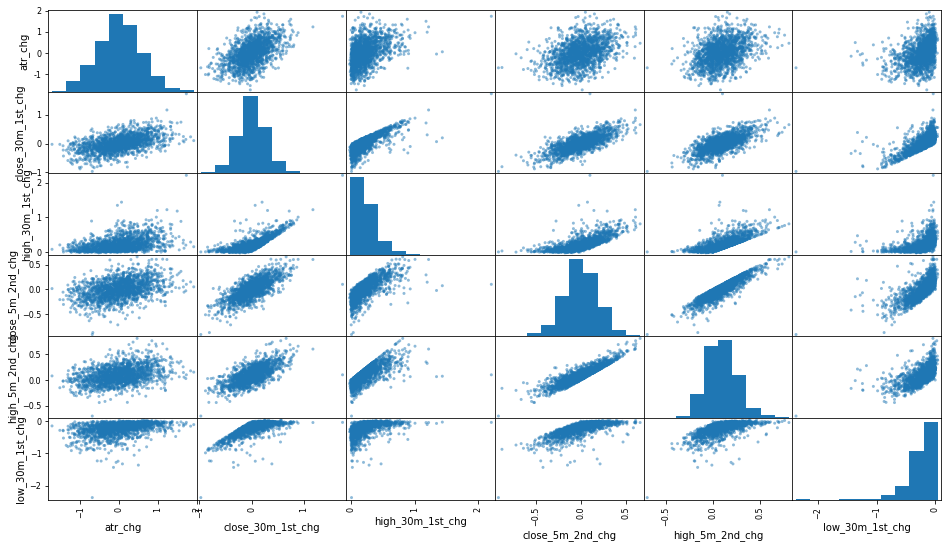

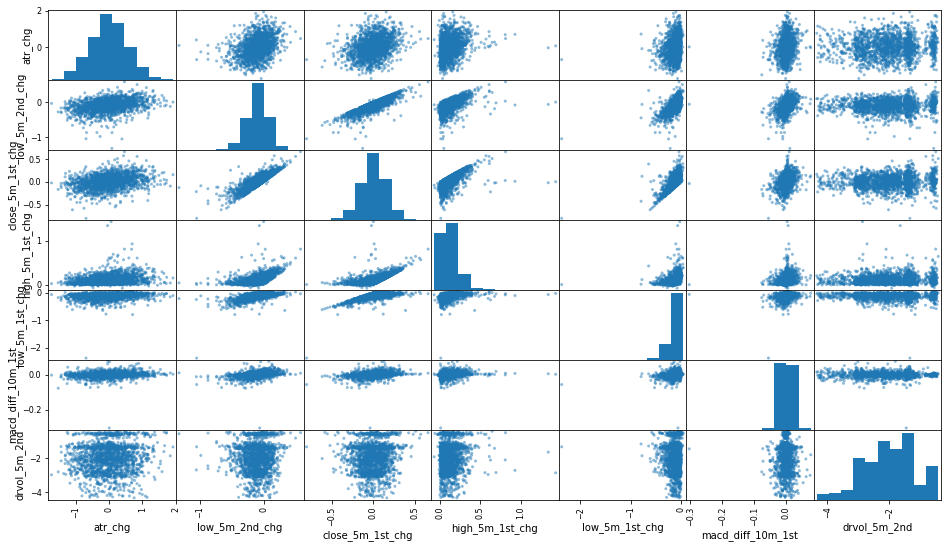

In [12]:
from pandas.plotting import scatter_matrix
# Nonseparable Data 
# positive correlation
attributes = ['atr_chg', "close_30m_1st_chg", "high_30m_1st_chg", "close_5m_2nd_chg", "high_5m_2nd_chg", "low_30m_1st_chg"] 
scatter_matrix(train_o[attributes], figsize=(16, 9));
attributes = ['atr_chg', "low_5m_2nd_chg", "close_5m_1st_chg", "high_5m_1st_chg", "low_5m_1st_chg", "macd_diff_10m_1st", "drvol_5m_2nd"] 
scatter_matrix(train_o[attributes], figsize=(16, 9));

# negative correlation


close_30m_1st_chg              1.000000
high_30m_1st_chg               0.773430
close_5m_2nd_chg               0.739831
low_30m_1st_chg                0.707591
high_5m_2nd_chg                0.685247
low_5m_2nd_chg                 0.641262
close_5m_1st_chg               0.578073
atr_chg                        0.515026
close2nd_of_close1st_chg       0.445629
low_5m_1st_chg                 0.406989
high_5m_1st_chg                0.403204
close_of_low_1st_chg           0.353915
close_of_low_2nd_chg           0.297125
macd_diff_10m_1st              0.258670
close_of_prelow_5m_2nd_chg     0.118057
drvol_5m_4th                   0.068622
drvol_5m_5th                   0.068353
drvol_5m_3rd                   0.068341
drvol_5m_6th                   0.068231
drvol_5m_2nd                   0.067796
drvol_5m_1st                   0.063154
close_of_prelow_5m_1st_chg     0.056329
macd_value_10m_1st             0.036764
atr_label                      0.022117
ema_trend_10m_1st              0.008031


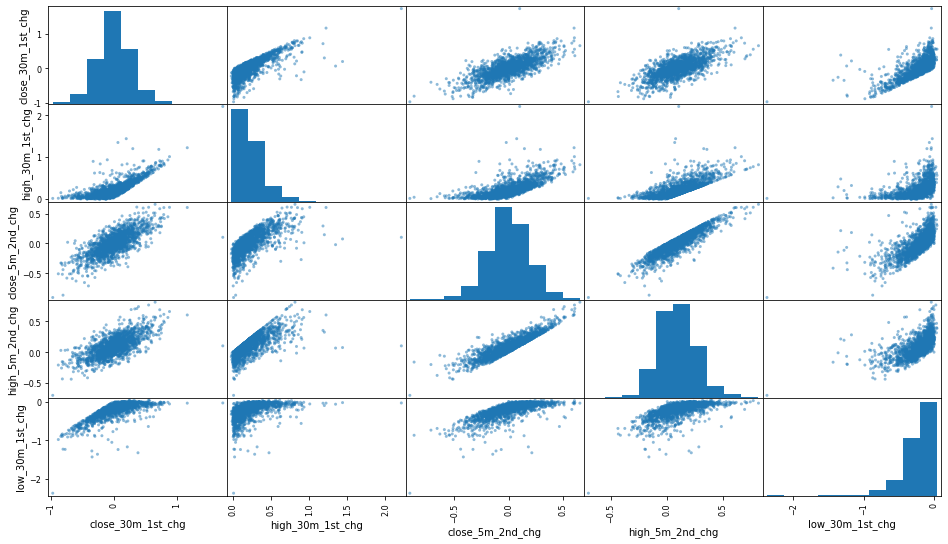

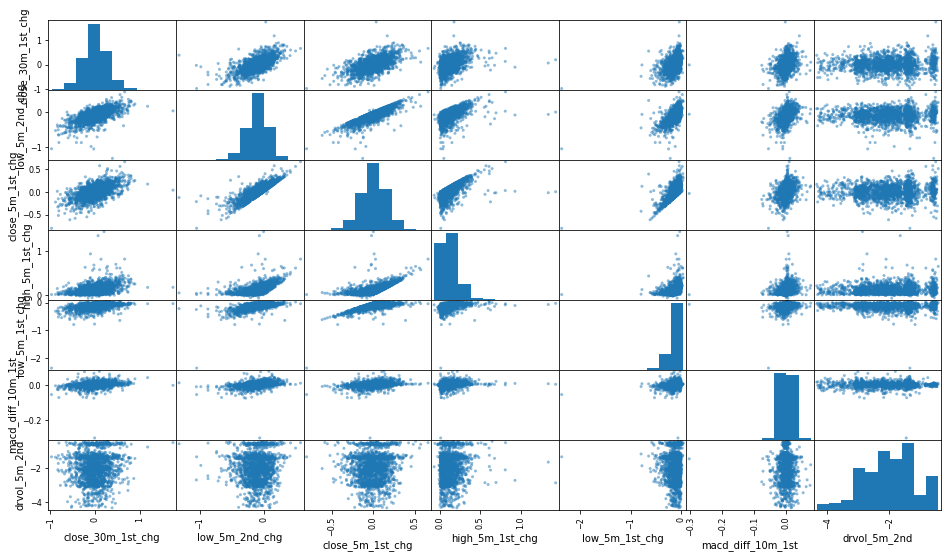

In [13]:
attributes = ['month', 'gap', 'angle_2d', 'momo_90d', 'ema21', 'ema50', 'ema200',
       'drvol_5m_1st', 'drvol_5m_2nd', 'drvol_5m_3rd', 'drvol_5m_4th',
       'drvol_5m_5th', 'drvol_5m_6th', 'macd_10m_1st', 'macd_value_10m_1st',
       'atr_chg', 'atr_label', 'avg50_volume_m', 'high_5m_1st_chg',
       'low_5m_1st_chg', 'close_5m_1st_chg', 'close_of_prehigh_5m_1st_chg',
       'close_of_prelow_5m_1st_chg', 'close_of_high_1st_chg',
       'close_of_low_1st_chg', 'high_5m_2nd_chg', 'low_5m_2nd_chg',
       'close_5m_2nd_chg', 'close_of_prehigh_5m_2nd_chg',
       'close_of_prelow_5m_2nd_chg', 'close_of_high_2nd_chg',
       'close_of_low_2nd_chg', 'close2nd_of_close1st_chg', 'high_30m_1st_chg',
       'low_30m_1st_chg', 'close_30m_1st_chg', 'macd_diff_10m_1st',
       'ema_trend_10m_1st']
print(train_o[attributes].corr()['close_30m_1st_chg'].sort_values(ascending=False) )

attributes = ["close_30m_1st_chg",  "high_30m_1st_chg", "close_5m_2nd_chg", "high_5m_2nd_chg", "low_30m_1st_chg"] 
scatter_matrix(train_o[attributes], figsize=(16, 9));
attributes = ['close_30m_1st_chg', "low_5m_2nd_chg", "close_5m_1st_chg", "high_5m_1st_chg", "low_5m_1st_chg", "macd_diff_10m_1st", "drvol_5m_2nd"] 
scatter_matrix(train_o[attributes], figsize=(16, 9));

In [14]:
#create test set
test_o = trim_data(dfd_all, validation_start, validation_end)
test_o.dropna(inplace=True)
test_o = feature_extraction_daily(test_o)
test_o = binary_feature_extraction_daily(test_o)
test_o = handle_text_columns(test_o)
test_o = drop_useless_columns(test_o)
test_o.reset_index(drop=True, inplace=True)
test_y = test_o['atr_label']
test_x = test_o.drop(['atr_chg', 'atr_label'], axis=1)
print(test_x.shape)
print(test_y.shape)

C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['Down Trend' 'Range' 'Up Trend']
(1006, 36)
(1006,)


In [15]:
# Model selection
train_o.reset_index(drop=True, inplace=True)
train_o

month       gap   angle_2d  momo_90d      ema21      ema50     ema200  \
0         2 -0.625978  -1.391195  0.025229   3.252960   3.264032   3.277828   
1         2  0.153374  -3.678239  0.039422   3.256328   3.265051   3.277949   
2         2 -0.303951  -1.881898  0.058721   3.270752   3.270931   3.279313   
3         3  0.732064  -7.165309  0.087743   3.285229   3.277169   3.280812   
4         3 -0.145773  -0.818455  0.120290   3.295663   3.281986   3.281998   
...     ...       ...        ...       ...        ...        ...        ...   
1713     12 -0.140601   7.977638  1.820603  45.684943  44.484179  38.903250   
1714     12  0.377277   3.833088  1.785951  45.758584  44.563035  38.978789   
1715     12  0.182815 -17.357753  1.748507  45.823258  44.637818  39.053329   
1716     12  0.032279  -0.433803  1.701736  45.860689  44.700453  39.124788   
1717     12 -0.216286  14.578050  1.649537  45.880627  44.754553  39.193994   

      drvol_5m_1st  drvol_5m_2nd  drvol_5m_3rd  ...  \
0        -0.464221     -0.465652     -0.467924  ...   
1        -0.465871     -0.462209     -0.463623  ...   
2        -0.469156     -0.473298     -0.471421  ...   
3        -0.454377     -0.461750     -0.454983  ...   
4        -0.468099     -0.468486     -0.468739  ...   
...            ...           ...           ...  ...   
1713     -1.186537     -1.201831     -1.213918  ...   
1714     -1.165183     -1.175191     -1.179492  ...   
1715     -1.127029     -1.138106     -1.137803  ...   
1716     -1.075197     -1.086501     -1.083555  ...   
1717     -1.051734     -1.057163     -1.038216  ...   

      close_of_prehigh_5m_2nd_chg  close_of_prelow_5m_2nd_chg  \
0                       -0.631759                    0.684405   
1                        0.000000                    1.302219   
2                       -1.318561                    0.354997   
3                        0.000000                    1.844613   
4                       -0.469850                    0.234925   
...                           ...                         ...   
1713                    -0.498255                    0.389939   
1714                    -0.765054                    1.228723   
1715                    -0.294029                    0.294029   
1716                    -0.611556                   -0.078071   
1717                    -1.063676                   -0.079776   

      close_of_high_2nd_chg  close_of_low_2nd_chg  close2nd_of_close1st_chg  \
0                  0.105293              0.105293                  0.105293   
1                  0.000000              0.113236                  0.113236   
2                  0.101428              0.101428                  0.101428   
3                  0.217013              0.108507                 -0.217013   
4                  0.117462              0.000000                  0.000000   
...                     ...                   ...                       ...   
1713               0.216633              0.129980                  0.086653   
1714               0.347752              0.023183                 -0.347752   
1715               0.076703              0.051135                 -0.076703   
1716               0.026024              0.052047                  0.000000   
1717               0.212735              0.026592                 -0.079776   

      high_30m_1st_chg  low_30m_1st_chg  close_30m_1st_chg  macd_diff_10m_1st  \
0             0.473819        -0.052647           0.473819          -0.002000   
1             0.283091        -0.056618           0.169855           0.001292   
2             0.304283         0.000000           0.304283          -0.002189   
3             0.325520        -0.325520          -0.217013           0.001335   
4             0.176194        -0.058731          -0.058731           0.000456   
...                ...              ...                ...                ...   
1713          0.335781        -0.509087          -0.314118           0.011840   
1714          0.25

In [16]:
train_y = train_o['atr_label']
train_x = train_o.drop(['atr_chg', 'atr_label'], axis=1)
print(train_x.shape)
print(train_y.shape)

(1718, 36)
(1718,)


In [17]:
import numpy as np
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

shuffle_index = np.random.permutation(1718) 
X_train, y_train = train_x.iloc[shuffle_index], train_y.iloc[shuffle_index] 

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train)
sgd_clf.score(test_x,test_y)

0.47514910536779326

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

param_grid = {'random_state': [10, 100, 1000]}
gridSearch_clf = GridSearchCV(SGDClassifier(), param_grid, cv=5, scoring=make_scorer(accuracy_score))
gridSearch_clf.fit(X_train, y_train)
gridSearch_clf.score(test_x,test_y)

0.5775347912524851

0.658051689860835
Feature ranking:
1. feature 26 (0.092992)
2. feature 19 (0.086216)
3. feature 33 (0.062104)
4. feature 32 (0.053324)
5. feature 2 (0.034911)
6. feature 31 (0.033623)
7. feature 17 (0.030127)
8. feature 25 (0.029947)
9. feature 24 (0.029641)
10. feature 23 (0.028455)
11. feature 27 (0.028328)
12. feature 21 (0.026540)
13. feature 13 (0.026152)
14. feature 16 (0.024904)
15. feature 22 (0.024341)
16. feature 18 (0.024036)
17. feature 14 (0.023890)
18. feature 28 (0.023656)
19. feature 3 (0.022953)
20. feature 20 (0.022626)
21. feature 1 (0.022490)
22. feature 30 (0.022311)
23. feature 34 (0.021566)
24. feature 29 (0.020737)
25. feature 6 (0.018904)
26. feature 4 (0.018423)
27. feature 35 (0.017987)
28. feature 5 (0.015859)
29. feature 7 (0.015428)
30. feature 8 (0.014748)
31. feature 10 (0.014334)
32. feature 11 (0.014293)
33. feature 12 (0.014057)
34. feature 9 (0.013552)
35. feature 15 (0.013422)
36. feature 0 (0.013122)


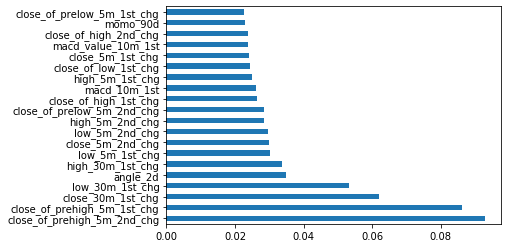

In [19]:
from sklearn.ensemble import RandomForestClassifier
rft_clf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
#rft_clf = RandomForestClassifier(n_estimators=440, max_depth=100, min_samples_leaf=4, min_samples_split=0.1, max_features=0.26, n_jobs=-1, random_state=0, bootstrap=True)
rft_clf.fit(X_train, y_train)
y_pred = rft_clf.predict(test_x)
print(accuracy_score(test_y, y_pred) )

importances = rft_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rft_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
feat_importances = pd.Series(rft_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
#0.701789

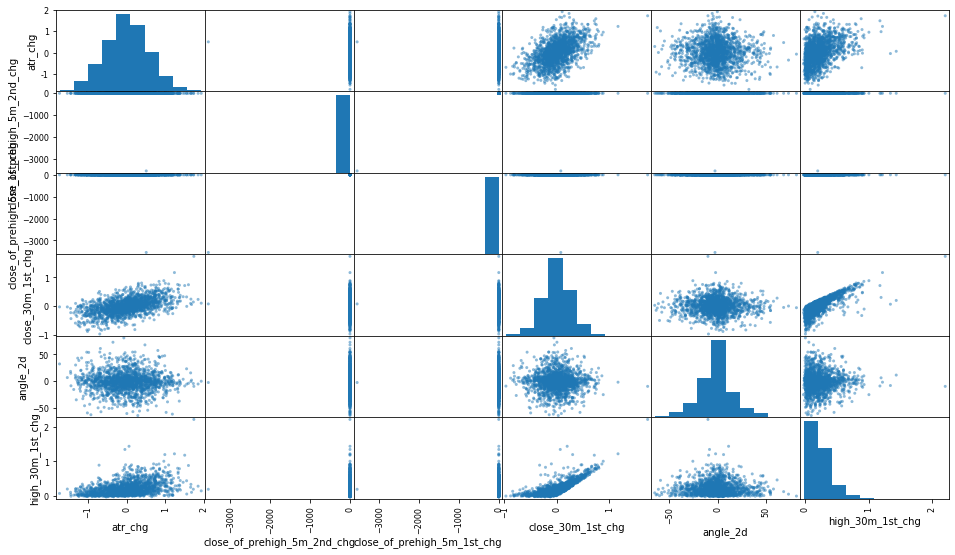

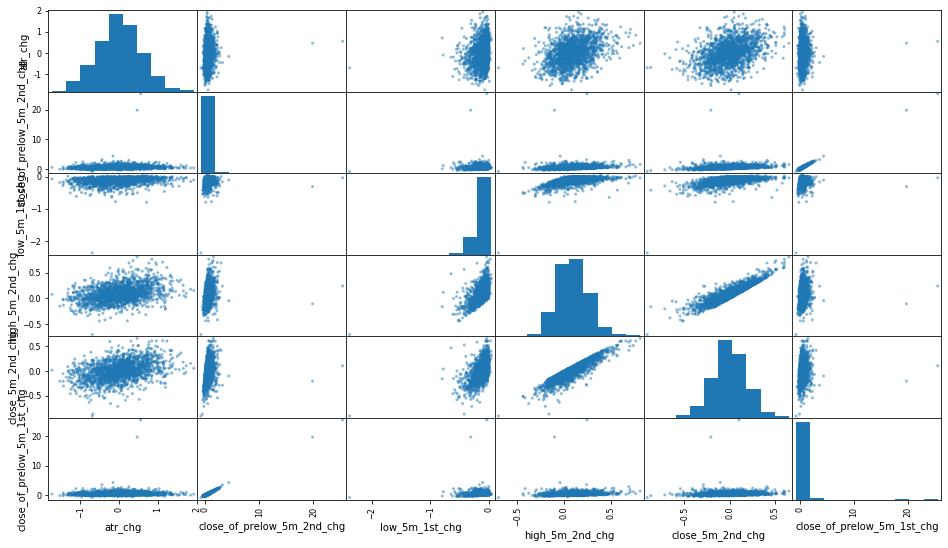

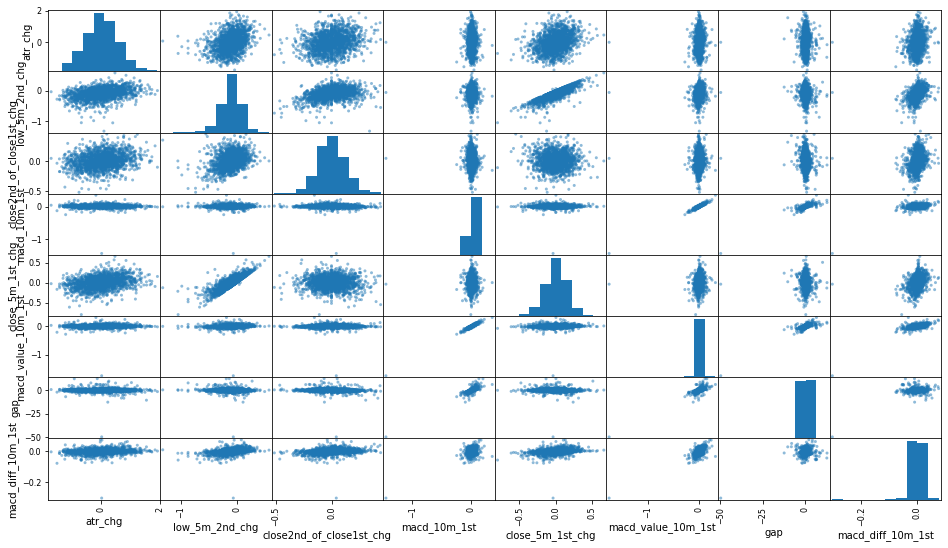

In [20]:
from pandas.plotting import scatter_matrix

attributes = ['atr_chg', "close_of_prehigh_5m_2nd_chg", "close_of_prehigh_5m_1st_chg", "close_30m_1st_chg", "angle_2d", "high_30m_1st_chg"] 
scatter_matrix(train_o[attributes], figsize=(16, 9));
attributes = ['atr_chg', "close_of_prelow_5m_2nd_chg", "low_5m_1st_chg", "high_5m_2nd_chg", "close_5m_2nd_chg", "close_of_prelow_5m_1st_chg"] 
scatter_matrix(train_o[attributes], figsize=(16, 9));
attributes = ['atr_chg', "low_5m_2nd_chg", "close2nd_of_close1st_chg", "macd_10m_1st", "close_5m_1st_chg", "macd_value_10m_1st", "gap", "macd_diff_10m_1st"] 
scatter_matrix(train_o[attributes], figsize=(16, 9));

In [38]:
train_o.loc[train_o['close_of_prehigh_5m_2nd_chg'] < -3000]

month      gap  angle_2d  momo_90d     ema21     ema50    ema200  \
602      7 -0.06605 -2.801167  0.265148  7.927651  8.401217  8.767247   

     drvol_5m_1st  drvol_5m_2nd  drvol_5m_3rd  ...  \
602     -2.171218     -2.203228     -2.194356  ...   

     close_of_prehigh_5m_2nd_chg  close_of_prelow_5m_2nd_chg  \
602                 -3551.694859                    0.474985   

     close_of_high_2nd_chg  close_of_low_2nd_chg  close2nd_of_close1st_chg  \
602               0.061288              0.091933                 -0.061288   

     high_30m_1st_chg  low_30m_1st_chg  close_30m_1st_chg  macd_diff_10m_1st  \
602          0.199187        -0.260476           0.076611          -0.001079   

     ema_trend_10m_1st  
602                  2  

[1 rows x 38 columns]

In [21]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform, truncnorm, randint

# print('Parameters currently in use:\n')
# print(rft_clf.get_params())

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 4, stop = 1000, num = 10)]
# # Number of features to consider at every split
# max_features = truncnorm(a=0, b=1, loc=0.25, scale=0.1)
# #max_features.append('auto')
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = uniform(0.01, 0.199)
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# print(random_grid)

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_rs = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=random_grid,
#                               n_iter = 100, scoring='neg_mean_absolute_error', 
#                               cv = 3, verbose=2, random_state=42, n_jobs=-1,
#                               return_train_score=True)


# rf_rs.fit(X_train, y_train*1)
# print(rf_rs.best_params_)


# best_rs = rf_rs.best_estimator_
# y_pred = best_rs.predict(test_x)
# accuracy_score(test_y*1, y_pred) 

In [22]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [10, 20, 50, 80, 100],
#     'max_features': [0.1, 0.2, 0.5, 0.8],
#     'min_samples_leaf': [3, 4, 5],
#     'n_estimators': [100, 200, 300, 1000]
# }
# rf_gs = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
# # Fit the random search model
# rf_gs.fit(X_train, y_train)
# print(rf_gs.best_params_)


# best_gs = rf_gs.best_estimator_
# y_pred = best_gs.predict(test_x)
# accuracy_score(test_y, y_pred) 

In [23]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.score(test_x,test_y))
dic = xgb_clf.get_booster().get_score(importance_type='weight')
sorted(dic.items(), key=lambda x: x[1], reverse=True)

0.6600397614314115


[('close_30m_1st_chg', 183),
 ('close_of_prehigh_5m_2nd_chg', 92),
 ('close_of_prehigh_5m_1st_chg', 80),
 ('ema_trend_10m_1st', 79),
 ('low_30m_1st_chg', 65),
 ('low_5m_1st_chg', 46),
 ('close_5m_1st_chg', 42),
 ('macd_10m_1st', 17),
 ('angle_2d', 16),
 ('macd_diff_10m_1st', 14),
 ('gap', 13),
 ('close2nd_of_close1st_chg', 11),
 ('close_of_high_1st_chg', 7),
 ('momo_90d', 7),
 ('drvol_5m_5th', 7),
 ('close_of_low_2nd_chg', 6),
 ('low_5m_2nd_chg', 4),
 ('drvol_5m_2nd', 4),
 ('close_of_prelow_5m_1st_chg', 4),
 ('high_5m_2nd_chg', 2),
 ('ema21', 1)]

In [24]:
scores = cross_val_score(xgb_clf, X_train, y_train, scoring="f1_macro", cv=5)
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
display_scores(scores)

Scores: [0.61951667 0.59101388 0.62905452 0.59700504 0.60786077]
Mean: 0.609
Std: 0.014


In [25]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
y_pred = gnb_clf.fit(X_train, y_train).predict(test_x)
print(gnb_clf.score(test_x,test_y))
print("Number of mislabeled points out of a total %d points : %d" % (test_x.shape[0], (test_y != y_pred).sum()))

0.5815109343936382
Number of mislabeled points out of a total 1006 points : 421


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(test_x)
print('The accuracy of the Logistic Regression is',round(accuracy_score(y_pred_lr,test_y)*100,2))

The accuracy of the Logistic Regression is 60.04


C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

def throttling(arr, thres):
    #res = arr.copy()
    res = np.zeros(len(arr))
    res[arr >= thres] = int(1)
    res[arr < thres] = int(0)
    return res

def baselineNN(dims):
    model = Sequential()
    model.add(Dense(10, input_dim=dims, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def use_keras_nn_model(x, y, xx, yy, epochs):
    model = baselineNN(x.shape[1])
    model.fit(x.as_matrix(), y.as_matrix(), epochs=epochs)
    y_pred = model.predict(xx.as_matrix()).reshape(xx.shape[0],)
    return y_pred, model

y_pred_nn, model_nn = use_keras_nn_model(X_train, y_train, test_x, test_y, 100)
print('The accuracy of the Neural Network is',round(accuracy_score(throttling(y_pred_nn, 0.6), test_y)*100,2))

Using TensorFlow backend.
C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\tenso

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 1/100
1718/1718 [==============================] - 0s 104us/step - loss: 2.8073 - accuracy: 0.5722
Epoch 2/100
1718/1718 [==============================] - 0s 34us/step - loss: 1.9666 - accuracy: 0.5506
Epoch 3/100
1718/1718 [==============================] - 0s 34us/step - loss: 1.2903 - accuracy: 0.5343
Epoch 4/100
1718/1718 [==============================] - 0s 28us/step - loss: 0.9219 - accuracy: 0.5215
Epoch 5/100
1718/1718 [==============================] - 0s 34us/step - loss: 0.7824 - accuracy: 0.5250
Epoch 6/100
1718/1718 [==============================] - 0s 34us/step - loss: 0.7342 - accuracy: 0.5419
Epoch 7/100
1718/1718 [==============================] - 0s 34us/step - loss: 0.7019 - accuracy: 0.5908
Epoch 8/100
1718/1718 [==============================] - 0s 29us/step - loss: 0.7035 - accuracy: 0.6164
Epoch 9/100
1718/1718 [==============================] - 0s 27us/step - loss: 0.6892 - accuracy: 0.6182
Epoch 10/100
1718/1718 [==============================] - 0s 26

1718/1718 [==============================] - 0s 28us/step - loss: 0.6492 - accuracy: 0.6368
Epoch 80/100
1718/1718 [==============================] - 0s 27us/step - loss: 0.6421 - accuracy: 0.6350
Epoch 81/100
1718/1718 [==============================] - 0s 27us/step - loss: 0.6451 - accuracy: 0.6362
Epoch 82/100
1718/1718 [==============================] - 0s 27us/step - loss: 0.6477 - accuracy: 0.6345
Epoch 83/100
1718/1718 [==============================] - 0s 27us/step - loss: 0.6468 - accuracy: 0.6356
Epoch 84/100
1718/1718 [==============================] - 0s 26us/step - loss: 0.6451 - accuracy: 0.6350
Epoch 85/100
1718/1718 [==============================] - 0s 27us/step - loss: 0.6464 - accuracy: 0.6356
Epoch 86/100
1718/1718 [==============================] - 0s 28us/step - loss: 0.6442 - accuracy: 0.6414
Epoch 87/100
1718/1718 [==============================] - 0s 28us/step - loss: 0.6461 - accuracy: 0.6362
Epoch 88/100
1718/1718 [==============================] - 0s 30us/st

C:\Users\Gao\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [28]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(rft_clf, n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_scores = cross_val_score(ada_clf, X_train, y_train, cv=5)
ada_scores.mean()

0.7118719913214455

In [29]:
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(test_x)
accuracy_score(test_y, y_pred) 

0.6540755467196819

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
gb_clf.score(test_x,test_y)

0.6500994035785288

In [31]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(rft_clf, n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True) 
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(test_x)
print(bag_clf.oob_score_)
accuracy_score(test_y, y_pred) 

#0.700795

0.7159487776484285


0.6640159045725647

In [32]:
# from sklearn.externals import joblib
# file = "bagging_rft_" + str(accuracy_score(test_y, y_pred)) + ".pkl"
# joblib.dump(bag_clf, file)
# # #my_model_loaded = joblib.load("my_model.pkl") 

In [33]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
rbf_kernel_svm_clf = Pipeline((        
    ("scaler", StandardScaler()),        
    ("svm_clf", SVC(kernel="rbf", gamma='auto', C=100))    
))
rbf_kernel_svm_clf.fit(X_train, y_train)
y_pred = rbf_kernel_svm_clf.predict(test_x)
accuracy_score(test_y, y_pred) 

0.5139165009940357

In [34]:
# from sklearn.ensemble import VotingClassifier

# voting_clf = VotingClassifier(estimators=[('xgb', xgb_clf), ('bag', bag_clf), ('rft', rft_clf), ('ada', ada_clf)], voting='hard') 
# voting_clf.fit(X_train, y_train) 
# print(voting_clf.score(test_x,test_y))

# # for clf in (xgb_clf, bag_clf, rft_clf, ada_clf, voting_clf):
# #     clf.fit(X_train, y_train)
# #     y_pred = clf.predict(test_x)
# #     #print(clf.score(test_x,test_y))
# #     print(clf.__class__.__name__, clf.score(test_x,test_y))

In [35]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
stacking_clf = StackingClassifier(estimators=[('xgb', xgb_clf), ('bag', bag_clf), ('rft', rft_clf), ('ada', ada_clf)], 
                         final_estimator=LogisticRegression()
                        )
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(test_x)
accuracy_score(test_y, y_pred) 
#0.701

0.6650099403578529

In [36]:
# from sklearn.externals import joblib
# file = "stacking_baggingrft_rft_xgb_adarft_" + str(accuracy_score(test_y, y_pred)) + ".pkl"
# joblib.dump(stacking_clf, file)